# Imports

In [155]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance

# Read cleaned csv file into a dataframe 

In [156]:
data_frame = gpd.read_file("geodatafile.shp")
data_frame.head(20)

,community_,total_popu,area,density,geometry
0,Auden Park,5230.0,0.000219,2.391120e+07,POLYGON ((-76.58918635660451 44.23781953260774...
1,Bayridge West,3045.0,0.000206,1.479967e+07,POLYGON ((-76.59061344049432 44.24262439991781...
2,Calvin Park,3630.0,0.000131,2.775684e+07,POLYGON ((-76.52545198378625 44.23016629443888...
3,Joyceville / Brewers Mills,1980.0,0.011303,1.751816e+05,POLYGON ((-76.24469013039291 44.41918642205587...
4,Kingscourt/Novelis(Alcan),4790.0,0.000833,5.751720e+06,POLYGON ((-76.53032981023402 44.27513372299433...
5,Alwington,1090.0,0.000071,1.526956e+07,"POLYGON ((-76.4994731896322 44.22254850387472,..."
6,Fairway Hills,2510.0,0.000302,8.318918e+06,POLYGON ((-76.53831405222454 44.23579975864179...
7,Grenville Park,1715.0,0.000141,1.216887e+07,"POLYGON ((-76.53059851131771 44.2500753358349,..."
8,Lemoine Point,1360.0,0.000809,1.681317e+06,POLYGON ((-76.59318756066864 44.23889740141339...
9,Sharpton / Glenvale,2030.0,0.010049,2.020159e+05,POLYGON ((-76.56821225223365 44.35732547661278...


# Get the city geometry 

In [157]:
shp_file_path = '/home/payam/workdir/data/neighbourhood-census-profiles-family-housing-mobility/neighbourhood-census-profiles-family-housing-mobility.shp'
shape_data_frame =  gpd.read_file(shp_file_path)
shape_data_frame.total_popul = shape_data_frame.total_popul.astype(float) #otherwise, operations will raise errors
city_row=shape_data_frame.iloc[19]
kingston_geom = city_row['geometry']


# Create a function that maps population density 

In [158]:
# This function takes a point in (x,y) -> (longtitude, lattitude) space and maps it to the population density 
# If the point is not wihtin the area of available data, it returns zero
def populaiton_density_profile ( lon, lat ):
    point = Point(lon,lat)
    for i, polygon in enumerate(data_frame.geometry) :
        if point.within(polygon) :
            return data_frame['density'].iloc[i]
    return 0

# Integration (binned sum) weighted by distance 

In [160]:
def distance_based_integrate (lon, lat, radius, nbins=20) :
    min_x = lon - radius
    max_x = lon + radius
    min_y = lat - radius
    max_y = lat + radius
    xs = np.arange(min_x,max_x, (max_x - min_x)/nbins) 
    ys = np.arange(min_y,max_y, (max_y - min_y)/nbins) 
    points = np.meshgrid(xs,ys)
    points = [(x,y) for x in xs for y in ys]
    pcf = 0 #Potential Custorme Flow 
    for point in points : 
        density=  populaiton_density_profile(point[0],point[1])
        if (distance.euclidean((lon,lat), point) > 0) : pcf += density/distance.euclidean((lon,lat), point)
    return pcf


# A function that integrates the function above within a radius 

In [161]:
def potential_customer_flow(lon, lat, radius):
    min_x = lon - radius
    max_x = lon + radius
    min_y = lat - radius
    max_y = lat + radius
    point = Point(lon,lat)
    if not point.within(kingston_geom) :
        return 0
    integral = distance_based_integrate(lon,lat,radius)
    return integral

In [162]:
lon , lat , radius = -76.5, 44.23, 0.1
potential_customer_flow(lon, lat, radius)

1.75995484750558e+20

# Plot the 2D density profile in a color map to visualize 

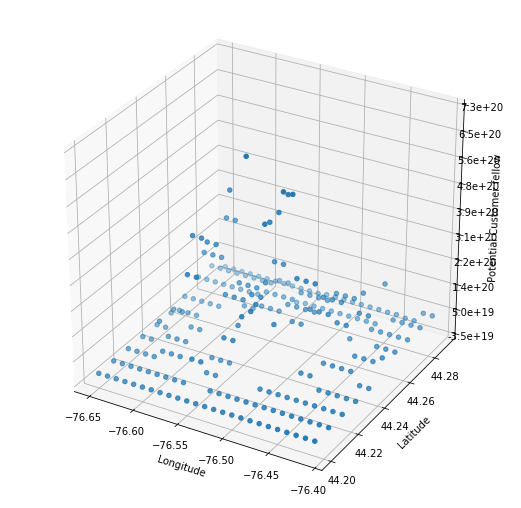

<Figure size 432x288 with 0 Axes>

In [163]:
radius = 0.1
def potential_customer_flow_2d(lon,lat) : #Because in the definition of the color map, a 2d function is needed
    return potential_customer_flow(lon, lat, radius)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(222, projection='3d')
lon = np.arange(-76.65, -76.4, 0.01)
lat = np.arange(44.2, 44.3, 0.01)
X, Y = np.meshgrid(lon, lat)

zs = np.array([potential_customer_flow_2d(lon, lat) for lon,lat in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01e'))

# Add a color bar which maps values to colors.
ax.scatter(X,Y,Z)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Potential Customer fellow')


plt.show()
plt.savefig('profiles_3d.png')

# Function to evaluate proximity/distance score

In [179]:
# This function sums all the distances to nearby businesses of the same type, this could be a good score. 
def distance_score (lon , lat, business_type, city):
    point = Point(lon,lat)
    if not point.within(kingston_geom) :
        return 0
    target_folder = '/home/payam/workdir/data/'
    target_filename = business_type + '_in_' + city
    trget_file_str =  target_folder + target_filename + '_cleaned.csv'
    df = pd.read_csv(trget_file_str)    
    coords = [(x,y) for x,y in zip(df['longitude'],df['latitude'])]
    distances = [distance.euclidean((lon,lat), point) for point in coords]
    return sum(distances)

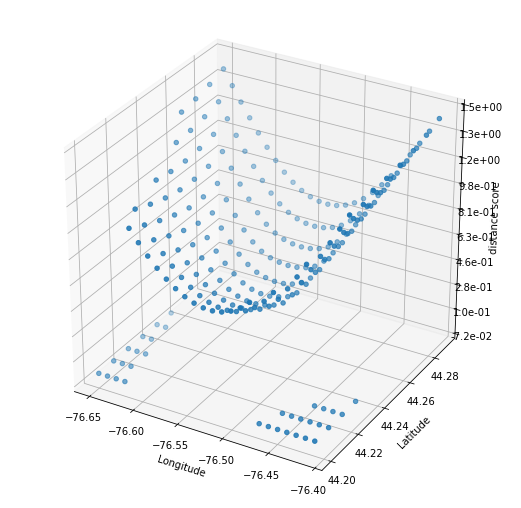

In [228]:
city = 'Kingston'
business_type = 'laundry'
def distance_score_2d(lon,lat) : #Because in the definition of the color map, a 2d function is needed
    return distance_score(lon, lat, business_type, city)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(222, projection='3d')
lon = np.arange(-76.65, -76.4, 0.01)
lat = np.arange(44.2, 44.3, 0.01)
X, Y = np.meshgrid(lon, lat)

zs = np.array([distance_score_2d(lon, lat) for lon,lat in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01e'))

# Add a color bar which maps values to colors.
ax.scatter(X,Y,Z)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('distance score')


plt.show()


In [229]:
target_folder = '/home/payam/workdir/data/'
target_filename = business_type + '_in_' + city
trget_file_str =  target_folder + target_filename + '_cleaned.csv'
df = pd.read_csv(trget_file_str)    
coords = [(x,y) for x,y in zip(df['longitude'],df['latitude'])]


# platypus optimization

In [230]:
from platypus import *

In [231]:
def belegundu(coords):
    lon = coords[0]
    lat = coords[1]
    return [np.log(potential_customer_flow_2d(lon,lat)+1) , distance_score_2d(lon,lat)]

In [315]:
problem = Problem(2, 2)
problem.types[:] = [Real(-76.65, -76.45), Real(44.21, 44.28)]
problem.function = belegundu
problem.directions[:] = [Problem.MAXIMIZE, Problem.MAXIMIZE]
algorithm = SPEA2(problem)
algorithm.run(1000)

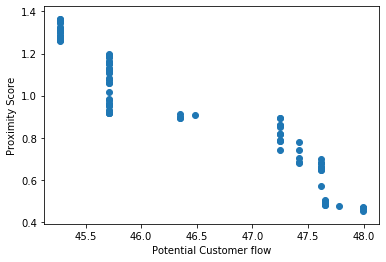

In [316]:
plt.scatter([s.objectives[0] for s in algorithm.result if s.feasible],
            [s.objectives[1] for s in algorithm.result if s.feasible])
#plt.xlim([44, 48])
#plt.ylim([0, 20])
plt.xlabel("Potential Customer flow")
plt.ylabel("Proximity Score")
#plt.show()
plt.savefig('SPEA2.png')

# Save the results in a csv file 

In [234]:
points = []
target_folder = '/home/payam/workdir/data/'
target_filename = business_type + '_in_' + city + '_results'
target_file_str =  target_folder + target_filename + '.csv'
for result in algorithm.result :
    lon = result.variables[0]
    lat = result.variables[1]
    pcf= result.objectives[0]
    ps= result.objectives[1]
    points.append({'lat':lat, 'lon':lon,'PCF':pcf, 'PS':ps})
df = pd.DataFrame(points)
# To normalize the PCF and PS columns [from 0 to 10]
df['PS_norm'] = ["{:0.2f}".format(i/max(df.PS)*10) for i in df.PS]
df['PCF_norm'] = ["{:0.2f}".format(i/max(df.PCF)*10) for i in df.PCF]
df.to_csv(target_file_str)

# Compare various algorithms 

In [254]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [255]:
def belegundu(coords):
    lon = coords[0]
    lat = coords[1]
    return [np.log(potential_customer_flow_2d(lon,lat)+1) , distance_score_2d(lon,lat)]
    problem = DTLZ2(3)

In [256]:
problem = Problem(2, 2)
problem.types[:] = [Real(-76.65, -76.45), Real(44.21, 44.28)]
problem.function = belegundu
problem.directions[:] = [Problem.MAXIMIZE, Problem.MAXIMIZE]

<Figure size 432x288 with 0 Axes>

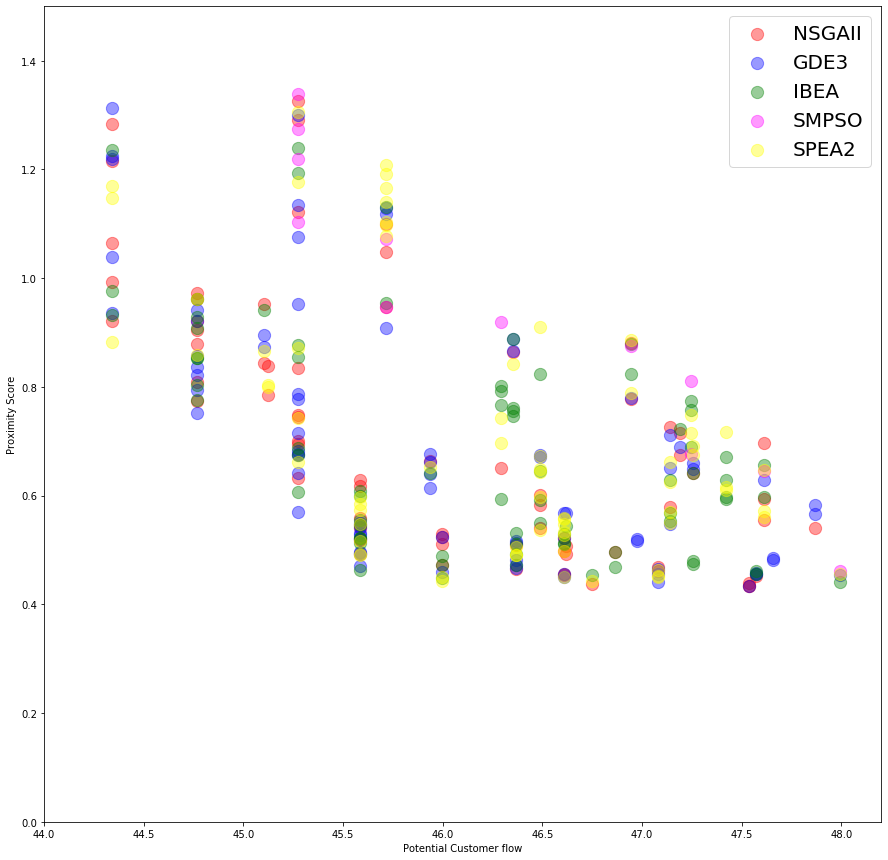

In [320]:
algorithms = [NSGAII,
                 GDE3,
                IBEA,
                 SMPSO,
                 SPEA2]

labels = ["NSGAII","GDE3","IBEA","SMPSO","SPEA2"]

colors = ["red", "blue", "green","magenta","yellow"]

# display the results
fig = plt.figure()
plt.figure(figsize=(15,15))
for i, algorithm in enumerate(algorithms):
    algorithm = algorithm(problem)
    algorithm.run(10)
    plt.scatter([s.objectives[0] for s in algorithm.result if s.feasible],
            [s.objectives[1] for s in algorithm.result if s.feasible] , color = colors[i], s =150, marker ='o', alpha =0.4, label =labels[i])

plt.xlim([44, 48.2])
plt.ylim([0, 1.5])
plt.xlabel("Potential Customer flow")
plt.ylabel("Proximity Score")   
plt.legend(prop={'size': 20})
plt.savefig('comparison_models_fast.png')
plt.show()
